# AI Explainability and Uncertainty Quantification

## <span style="color:Orange">Overview</span>

In this lecture, we will investigate what are some benefits of <span style="color:violet">Bayesian Neural Networks</span> (BNN) over point estimate Neural Networks. We will also look at other uncertainty quantification methods, including conformal prediction. 

Import standard libraries and setting random seeds for reproducibility.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

torch.manual_seed(42)
np.random.seed(42)

## <span style="color:Orange">Simulate Data</span>

Let's simulate a wiggly line and draw observations in separated regions...

In [2]:
def get_simple_data_train():
    x = np.linspace(-.2, 0.2, 500)
    x = np.hstack([x, np.linspace(.6, 1, 500)])
    eps = 0.02 * np.random.randn(x.shape[0])
    y = x + 0.3 * np.sin(2 * np.pi * (x + eps)) + 0.3 * np.sin(4 * np.pi * (x + eps)) + eps
    x_train = torch.from_numpy(x).float()[:, None]
    y_train = torch.from_numpy(y).float()
    return x_train, y_train

In [3]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.xlim([-.5, 1.5])
    plt.ylim([-1.5, 2.5])
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    x_train, y_train = get_simple_data_train()
    
    x_true = np.linspace(-.5, 1.5, 1000)
    y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)
    
    ax.plot(x_train, y_train, 'ko', markersize=4, label="observations")
    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, fontsize=15, frameon=False)
    plt.show()

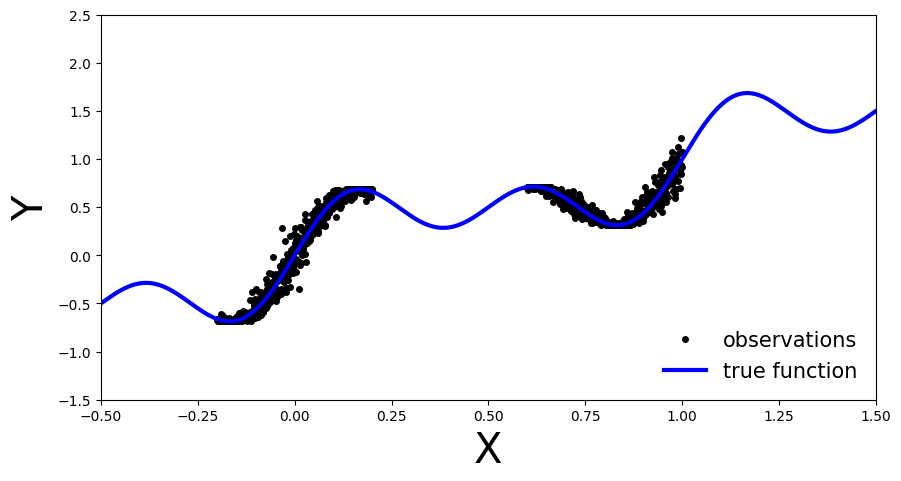

In [4]:
plot_generic()

As you can see, we have the true function in blue. The observations are observable in two regions of the function and there is some noise in their measurement. We will use this simple data to showcase the differences between BNNs and deterministic NNs.

## <span style="color:Orange">Define non-Bayesian Neural Network</span>

First let's create our point estimate neural network, in other words a standard fully connected MLP. We will define the number of hidden layers dynamically so we can reuse the same class for different depths.  We will also add a ___<span style="color:violet">dropout</span>___ flag, this will allow us to easily use the same architecture for our BNN. 

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean

## <span style="color:Orange">Train one deterministic NN</span>

### <span style="color:LightGreen">Training</span>

Now let's train our MLP with the training data we generated above:

In [6]:
def train(net, train_data):
    x_train, y_train = train_data
    optimizer = torch.optim.Adam(params=net.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(3000)
    for _ in progress_bar:
        optimizer.zero_grad()
        loss = criterion(y_train, net(x_train))
        progress_bar.set_postfix(loss=f'{loss / x_train.shape[0]:.3f}')
        loss.backward()
        optimizer.step()
    return net

In [7]:
train_data = get_simple_data_train()
x_test = torch.linspace(-.5, 1.5, 3000)[:, None]  # test over the whole range

net = MLP(hidden_dim=30, n_hidden_layers=2)
net = train(net, train_data)
y_preds = net(x_test).clone().detach().numpy()

  0%|          | 0/3000 [00:00<?, ?it/s]

### <span style="color:LightGreen">Evaluate</span>

Let's investigate how our deterministic MLP generalizes over the entire domain of our input variable $x$ (the model was only trained on the observations, now we will also pass in data outside this region)

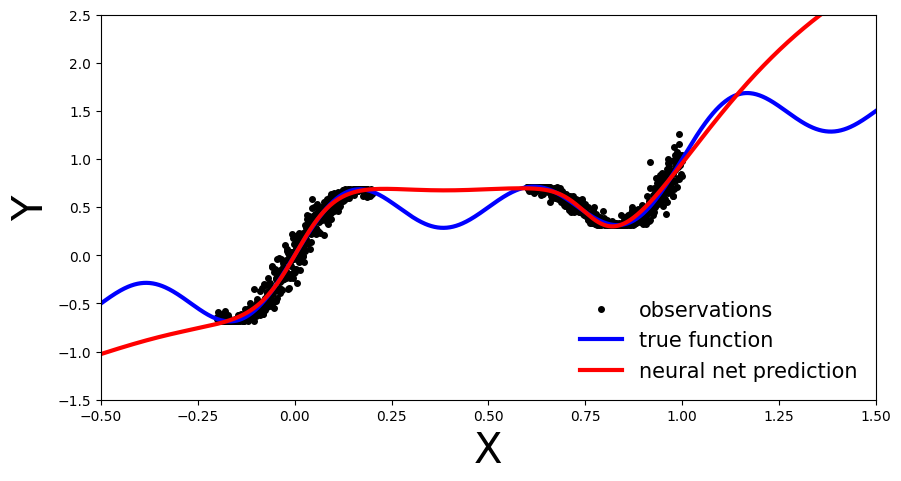

In [8]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'r-', linewidth=3, label='neural net prediction')

    plot_generic(add_predictions)
plot_predictions(x_test, y_preds)

We can see that our deterministic MLP (red line) has correctly learned the data distribution in the training regions, however, as the model has not learned the underlying sinusoidal wave function, it's predictions outside the training region are inaccurate. As our MLP is a point estimate NN we have no measure confidence in the predictions outside the training region. In the upcoming sections let's see how this compares to BNN.

## <span style="color:Orange">Deep Ensemble</span>

Deep ensembles were first introduced by [Lakshminarayanan et al. (2017)](https://arxiv.org/abs/1612.01474). As the name implies multiple point estimate NN are trained, ___<span style="color:violet">an ensemble</span>___, and the final prediction is computed as an average across the models. From a Bayesian perspective the different point estimates correspond to modes of a Bayesian posterior. This can be interpreted as approximating the posterior with a distribution parametrized as multiple Dirac deltas:

$$ \Large
q_{\phi}(\theta | D) = \sum_{\theta_{i} ∈ ϕ} \alpha_{\theta_{i}} δ_{\theta_{i}}(\theta)
$$

where $\alpha_{\theta_{i}}$ are positive constants such that their sum is equal to one.

### <span style="color:LightGreen">Training</span>

We will reuse the MLP architecture introduced before, simply now we will train an ensemble of such models

In [9]:
ensemble_size = 5
ensemble = [MLP(hidden_dim=30, n_hidden_layers=2) for _ in range(ensemble_size)]
for net in ensemble:
    train(net, train_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

### <span style="color:LightGreen">Evaluate</span>

Same as before, let's investigate how our Deep Ensemble performs on the entire data domain of our input variable $x$.

In [10]:
y_preds = [np.array(net(x_test).clone().detach().numpy()) for net in ensemble]

Plot each ensemble member's predictive function.

In [11]:
def plot_multiple_predictions(x_test, y_preds):
    def add_multiple_predictions(ax):
        for idx in range(len(y_preds)):
            ax.plot(x_test, y_preds[idx], '-', linewidth=3)

    plot_generic(add_multiple_predictions)

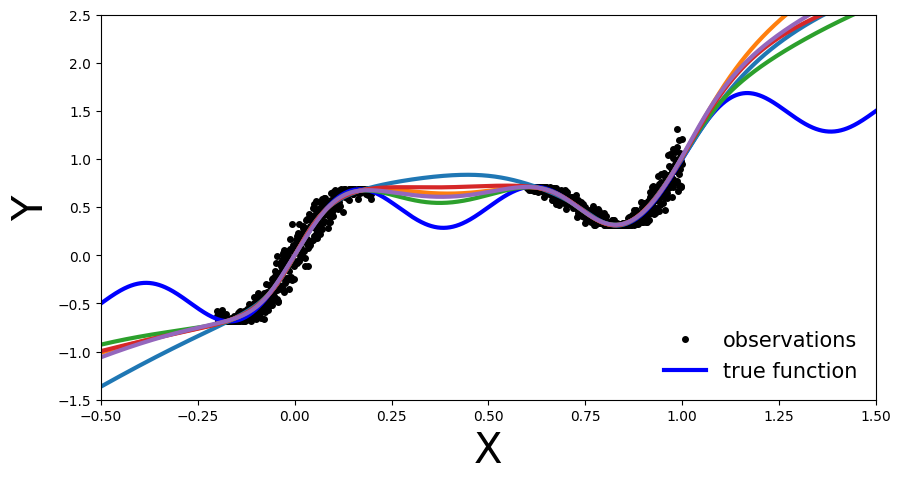

In [12]:
plot_multiple_predictions(x_test, y_preds)

In this plot the benefit of an ensemble approach is not immediately clear. Still on the regions outside the training data each of the trained NN is inaccurate. So, you might ask: "What is the benefit?"

Well let's plot the above in a slightly different way: let's visualize the ensemble's ___<span style="color:violet">uncertainty bands</span>___.
> From a Bayesian perspective we want to quantify the model's uncertainty on its prediction. This is done via the marginal $p(y|x, D)$, which can be computed as:

$$ \Large
p(y|x, D) = \int_{\theta}p(y|x,\theta')p(\theta'|D)d\theta'
$$

> In practice, for Deep Ensembles we approximate the above by computing the mean and standard deviation across the ensemble. Meaning $p(\theta|D)$ represents the parameters of one of the trained models, $\theta_{i} ∼ p(\theta|D)$, which we then use to compute $y_{i} = f(x,\theta_{i})$, representing $p(y|x,\theta')$.


In [13]:
def plot_uncertainty_bands(x_test, y_preds):
    y_preds = np.array(y_preds)
    y_mean = y_preds.mean(axis=0)
    y_std = y_preds.std(axis=0)

    def add_uncertainty(ax):
        ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="predictive mean")
        ax.fill_between(x_test.ravel(), y_mean - 2 * y_std, y_mean + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plot_generic(add_uncertainty)

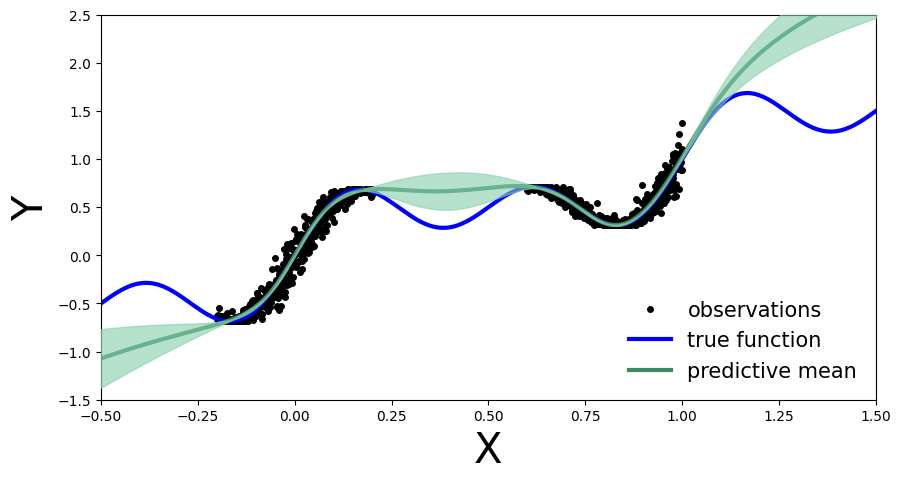

In [14]:
plot_uncertainty_bands(x_test, y_preds)

Now we see the benefit of a Bayesian approach. Outside the training region we not only have the point estimate, but also model's uncertainty about its prediction.

## <span style="color:Orange">Monte Carlo Dropout</span>

First we create our MC-Dropout Network. As you can see in the code below, creating a dropout network is extremely simple:
We can reuse our existing network architecture, the only alteration is that during the forward pass we randomly *switch off* (zero) some of the elements of the input tensor.

The Bayesian interpretation of MC-Dropout is that we can see each dropout configuration as a different sample from the approximate posterior distribution $\theta_{i} ∼ q(\theta|D)$. 


### <span style="color:LightGreen">Training</span>

In [15]:
net_dropout = MLP(hidden_dim=30, n_hidden_layers=2, use_dropout=True)
net_dropout = train(net_dropout, train_data)

  0%|          | 0/3000 [00:00<?, ?it/s]

### <span style="color:LightGreen">Evaluate</span>

Similarly to Deep Ensembles, we pass the test data multiple times through the MC-Dropout network. We do so to obtain $y_{i}$ at the different parameter settings, $\theta_{i}$ of the network, $y_{i}=f(x,\theta_{i})$, governed by the dropout mask.

>This is the main difference compared to dropout implementation in a deterministic NN where it serves as a regularization term. In normal dropout application during test time the dropout is **not** applied. Meaning that all connections are present, but the weights are [adjusted](https://cs231n.github.io/neural-networks-2/)

In [16]:
n_dropout_samples = 100

# compute predictions, resampling dropout mask for each forward pass
y_preds = [net_dropout(x_test).clone().detach().numpy() for _ in range(n_dropout_samples)]
y_preds = np.array(y_preds)

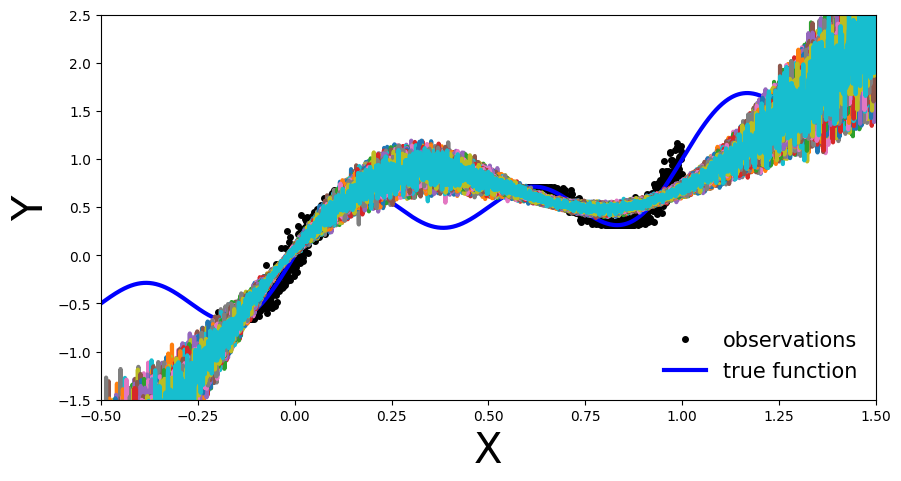

In [17]:
plot_multiple_predictions(x_test, y_preds)

In the above plot each colored line (apart from blue) represents a different parametrization, $\theta_{i}$, of our MC-Dropout Network. 

Likewise to the Deep Ensemble Network, we can also compute the MC-dropout's ___<span style="color:violet">uncertainty bands</span>___.

> The approach in practice is the same as before: we compute the mean and standard deviation across each dropout mask, which corresponds to the marginal estimation we discussed earlier.

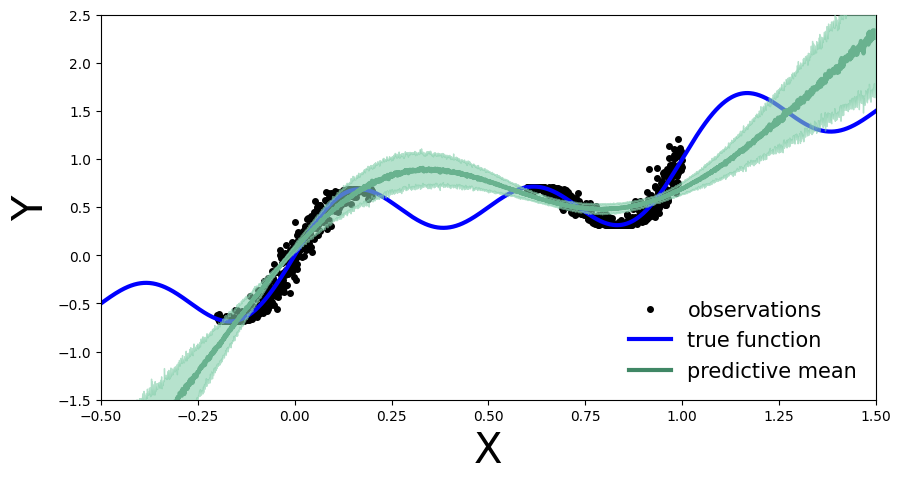

In [18]:
plot_uncertainty_bands(x_test, y_preds)

In the same way as Deep Ensembles, MC-Dropout allows us to have an uncertainty estimate next to our point wise predictions. However, for the given use-case this has come with the cost of an overall drop in the model's performance on the training regions. We observe this because at every pass through our network we randomly choose which nodes to keep, so one could argue that we hinder the networks optimal performance.

## <span style="color:Orange">Conformal Prediction</span>

<span style="color:violet">Conformal prediction</span> is a statistical uncertainty quantification approach that has gained interest in the Machine Learning community more recently. Originally proposed by [Vovk et al.](https://www.jmlr.org/papers/volume9/shafer08a/shafer08a.pdf), it allows us to construct statistically rigorous uncertainty bands around our predictions, without requiring any modifications to our prediction model. This is achieved by comparing true and predicted values on out-of-sample data (more precisely we are looking at _inductive_ conformal prediction), and computing an empirical quantile $\hat{q}$ based on these comparisons that defines the magnitude of the uncertainy bands. How we compare true and predicted values is a modelling decision, and there are different ways to do so. The comparison results are also called _(non)conformity scores_, hence the naming of the method.

If we follow the conformal recipe, with minimal assumptions our uncertainty bands will be statistically rigorous in the sense that they satisfy a nice property for any test sample $(X_{n+1},Y_{n+1})$:

$$ \Large
\mathbb{P}(Y_{n+1} \in \hat{C}(X_{n+1})) \ge 1-\alpha
$$

, i.e. with probability at least $1-\alpha$, our computed uncertainty band $\hat{C}(X_{n+1})$ around our point estimate $\hat{Y}_{n+1}$ will contain the _true_ unknown value $Y_{n+1}$. This is called a (marginal) coverage guarantee, and provides us with a measure of confidence in the quality of our uncertainty bands.

We will now see that the implementation of conformal prediction for our example is in fact very simple, which is part of its attractiveness.

### <span style="color:LightGreen">Training</span>

Firstly, we split our training samples into two different data sets, the true training set and a hold-out data set, which we call the calibration set (you can think of it as a specific kind of validation set). We will take 20% of our data for calibration. Usually this is a random sample, but for reproducebility we select them evenly spaced.

In [19]:
# split data into training and calibration sets
x, y = get_simple_data_train()
cal_idx = np.arange(len(x), step=1/0.2, dtype=np.int64)
# cal_idx = np.random.choice(len(x), size=int(len(x) * 0.2), replace=False) # random selection
mask = np.zeros(len(x), dtype=bool)
mask[cal_idx] = True
x_cal, y_cal = x[mask], y[mask]
x_train, y_train = x[~mask], y[~mask]

 Then, we train a single standard (non-Bayesian) MLP on the true training set:

In [20]:
net = MLP(hidden_dim=30, n_hidden_layers=2)
net = train(net, (x_train, y_train))

  0%|          | 0/3000 [00:00<?, ?it/s]

### <span style="color:LightGreen">Evaluate</span>

Same as before, we first visualize how the MLP performs on the entire data domain of our input variable $x$. We see that training it on only 80% instead of all available data did not notably change its performance.

In [21]:
# compute predictions everywhere
x_test = torch.linspace(-.5, 1.5, 1000)[:, None] 
y_preds = net(x_test).clone().detach().numpy()

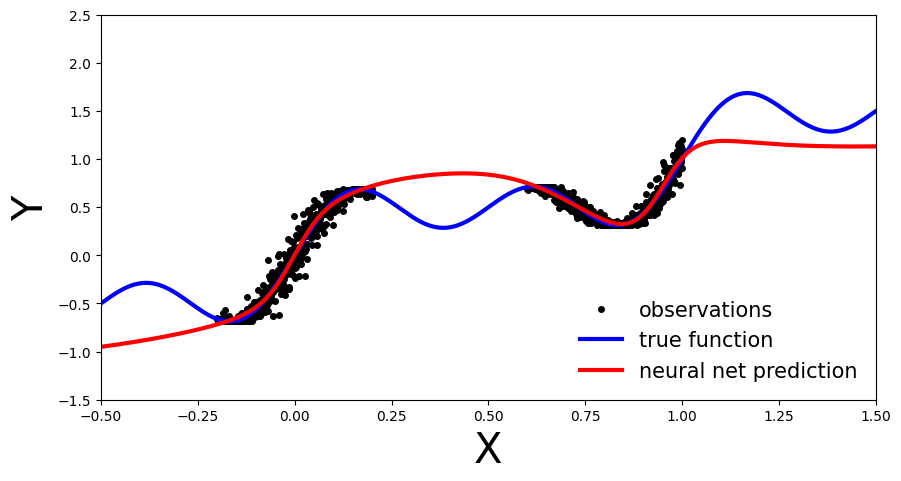

In [22]:
plot_predictions(x_test, y_preds)

We now perform the conformal prediction procedure to obtain our uncertainty bands. In the simplest case, our comparison of predicted and true values on the calibration data is achieved by simply looking at the residuals $|y-\hat{y}|$, which form our <span style="color:violet">conformity scores</span>. We then compute $\hat{q}$ as the 

$$ \Large
\left\lceil \frac{(n+1)(1-\alpha)}{n} \right\rceil
$$

empirical quantile of these residuals, and form our uncertainty bands for every test sample as 

$$ \Large
\hat{C}(X_{n+1})=[\hat{f}(x_{n+1})-\hat{q},\, \hat{f}(x_{n+1}) +\hat{q}]
$$

Our desired coverage rate is $(1-\alpha) \in [0,1]$, which we set to 90% (i.e. choose $\alpha=0.1$).


In [23]:
# compute calibration residuals
y_cal_preds = net(x_cal).clone().detach()
resid = torch.abs(y_cal - y_cal_preds).numpy()

In [24]:
# compute conformal quantile
alpha = 0.1
n = len(x_cal)
q_val = np.ceil((1 - alpha) * (n + 1)) / n
q = np.quantile(resid, q_val, method="higher")

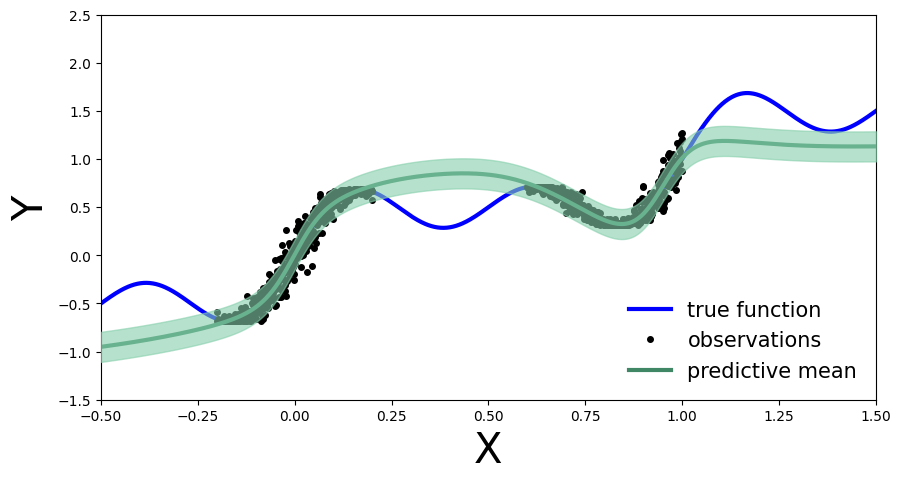

In [25]:
# true function
x_true = np.linspace(-.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true) 

# generate plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.xlim([-.5, 1.5])
plt.ylim([-1.5, 2.5])
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
ax.plot(x, y, 'ko', markersize=4, label="observations")
ax.plot(x_test, y_preds, '-', linewidth=3, color="#408765", label="predictive mean")
ax.fill_between(x_test.ravel(), y_preds - q, y_preds + q, alpha=0.6, color='#86cfac', zorder=5)

plt.legend(loc=4, fontsize=15, frameon=False);

We now obtain an uncertainty band around each test set prediction, which is informed by our performance on the calibration data (as quantified by the residuals). We can also compare our empirical coverage on the available test data against our target coverage of 90%:

In [26]:
# compute empirical coverage across whole test domain
cov = np.mean(((y_preds - q) <= y_true) * ((y_preds + q) >= y_true))
print(f"Empirical coverage: {cov:%}")

Empirical coverage: 49.100000%


We notice that the empirical coverage does not match our target coverage, suggesting that the conformal procedure is not working well for our given test samples (we are under-covering). This is mainly due to the fact that our calibration data, which is selected from available observations, is very localized and therefore not representative of the whole test domain. In other words, the information we get from the calibration data does not translate well to the whole test domain. Therefore the computed quantile $\hat{q}$ is inadequate on unseen sample spaces. Compare this to our empirical coverage for test samples from the domain of our calibration data:


In [27]:
# compute empirical coverage only on previously observed test domain
mask = (x_true >= -.2) * (x_true < 0.2) + (x_true >= .6) * (x_true < 1)
cov = np.mean(((y_preds[mask] - q) <= y_true[mask]) * ((y_preds[mask] + q) >= y_true[mask]))
print(f"Empirical coverage: {cov:%}")

Empirical coverage: 100.000000%


Here we are in fact over-covering, i.e. being overly conservative in the magnitude of our uncertainty bands. Note that the coverage guarantee only holds _marginally_, i.e. across _all possible_ sets of calibration and test samples; this is particularly obvious in our case. Other factors playing a role in obtaining useful uncertainty bands are the choice of $\alpha$, size of the calibration set and the predictive model's performance.

## <span style="color:Orange">Bayesian Neural Networks</span>

A Bayesian neural network is a probabilistic model that allows us to estimate uncertainty in predictions by representing the weights and biases of the network as probability distributions rather than fixed values. This allows us to *incorporate prior knowledge* about the weights and biases into the model, and *update our beliefs* about them as we observe data.

Mathematically, a Bayesian neural network can be represented as follows:

Given a set of input data $x$, we want to predict the corresponding output $y$. The neural network represents this relationship as a function $f(x, \theta)$, where $\theta$ are the weights and biases of the network. In a Bayesian neural network, we represent the weights and biases as probability distributions, so $f(x, \theta)$ becomes a probability distribution over possible outputs:

$$ \Large
p(y|x, \mathcal{D}) = \int p(y|x, \theta)p(\theta|\mathcal{D}) d\theta
$$

where $p(y|x, \theta)$ is the likelihood function, which gives the probability of observing $y$ given $x$ and $\theta$, and $p(\theta|\mathcal{D})$ is the posterior distribution over the weights and biases given the observed data $\mathcal{D}$.

To make predictions, we use the posterior predictive distribution:

$$ \Large
p(y^*|x^*, \mathcal{D}) = \int p(y^*|x^*, \theta)p(\theta|\mathcal{D}) d\theta
$$

where $x^*$ is a new input and $y^*$ is the corresponding predicted output.

To estimate the (intractable) posterior distribution $p(\theta|\mathcal{D})$, we can use either Markov Chain Monte Carlo (MCMC) or Variational Inference (VI).

## <span style="color:Orange">Simulate data</span>

Let's generate noisy observations from a sinusoidal function.

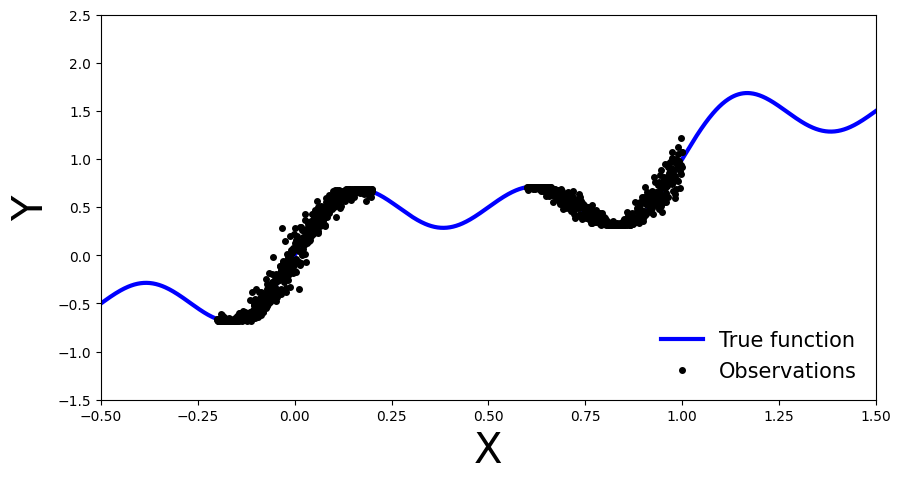

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set plot limits and labels
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

## <span style="color:Orange">Getting Started with Pyro</span>

In [29]:
%pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## <span style="color:Orange">Bayesian Neural Network with Gaussian Prior and Likelihood</span>

Our first Bayesian neural network employs a Gaussian prior on the weights and a Gaussian likelihood function for the data. The network is a shallow neural network with one hidden layer.

To be specific, we use the following prior on the weights $\theta$:

$$ \Large
p(\theta) = \mathcal{N}(\mathbf{0}, 10\cdot\mathbb{I})
$$

where $\mathbb{I}$ is the identity matrix.

To train the network, we define a likelihood function comparing the predicted outputs of the network with the actual data points:

$$ \Large
p(y_i| x_i, \theta) = \mathcal{N}\big(NN_{\theta}(x_i), \sigma^2\big)
$$

with prior $\sigma \sim \Gamma(1,1)$.

Here, $y_i$ represents the actual output for the $i$-th data point, $x_i$ represents the input for that data point, $\sigma$ is the standard deviation parameter for the normal distribution and $NN_{\theta}$ is the shallow neural network parameterized by $\theta$. 

Note that we use $\sigma^2$ instead of $\sigma$ in the likelihood function because we use a Gaussian prior on $\sigma$ when performing variational inference and then want to avoid negative values for the standard deviation.

In [30]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

## <span style="color:Orange">Define and run Markov chain Monte Carlo sampler</span>

To begin with, we can use MCMC to compute an <span style="color:Violet">unbiased estimate</span>
of 

$$ \Large
p(y|x, \mathcal{D}) = \mathbb{E}_{\theta \sim p(\theta|\mathcal{D})}\big[p(y|x,\theta)\big]
$$

through Monte Carlo sampling. Specifically, we can approximate 

$$ \Large
\mathbb{E}_{\theta \sim p(\theta|\mathcal{D})}\big[p(y|x,\theta)\big]
$$ 

as follows:

$$ \Large
\mathbb{E}_{\theta \sim p(\theta|\mathcal{D})}\big[p(y|x,\theta)\big] \approx \frac{1}{N} \sum_{i=1}^{N} p(y|x,\theta_{i})
$$

where

$$ \Large
\theta_{i} \sim p(\theta_i|\mathcal{D}) \propto p(\mathcal{D}|\theta)p(\theta)
$$

are samples drawn from the posterior distribution. Because the normalizing constant is intractable, we require MCMC methods like Hamiltonian Monte Carlo to draw samples from the non-normalized posterior.

Here, we use the No-U-Turn ([NUTS](https://arxiv.org/abs/1111.4246)) kernel.

In [31]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN()

# Set Pyro random seed
pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
nuts_kernel = NUTS(model, jit_compile=False)  # jit_compile=True is faster but requires PyTorch 1.6+

# Define MCMC sampler, get 50 posterior samples
mcmc = MCMC(nuts_kernel, num_samples=50)

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

# Run MCMC
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [00:57,  1.73it/s, step size=4.38e-04, acc. prob=0.978]


We calculate and plot the predictive distribution.

In [32]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)

In [33]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

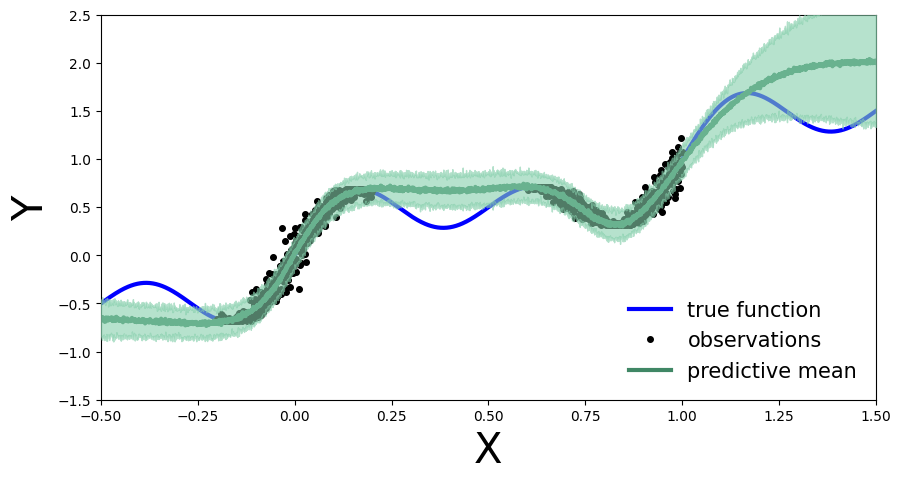

In [34]:
plot_predictions(preds)

## <span style="color:Orange"> Exercise 1: Deep Bayesian Neural Network</span>

We can define a deep Bayesian neural network in a similar fashion, with Gaussian priors on the weights: 

$$ \Large 
p(\theta) = \mathcal{N}(\mathbf{0}, 5\cdot\mathbb{I})
$$ 

The likelihood function is also Gaussian: 

$$ \Large
p(y_i| x_i, \theta) = \mathcal{N}\big(NN_{\theta}(x_i), \sigma^2\big)
$$

with $\sigma \sim \Gamma(0.5,1)$.

> Implement the deep Bayesian neural network and run MCMC to obtain posterior samples.
> Compute and plot the predictive distribution.
> Use the following network architecture: Number of hidden layers: 5, Number of hidden units per layer: 10, Activation function: Tanh, Prior scale: 5.

In [35]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

### <span style="color:LightGreen">Train the deep BNN with MCMC</span>

In [36]:
# define model and data
model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [02:24,  1.45s/it, step size=9.71e-04, acc. prob=0.866]


### <span style="color:LightGreen">Compute predictive distribution</span>

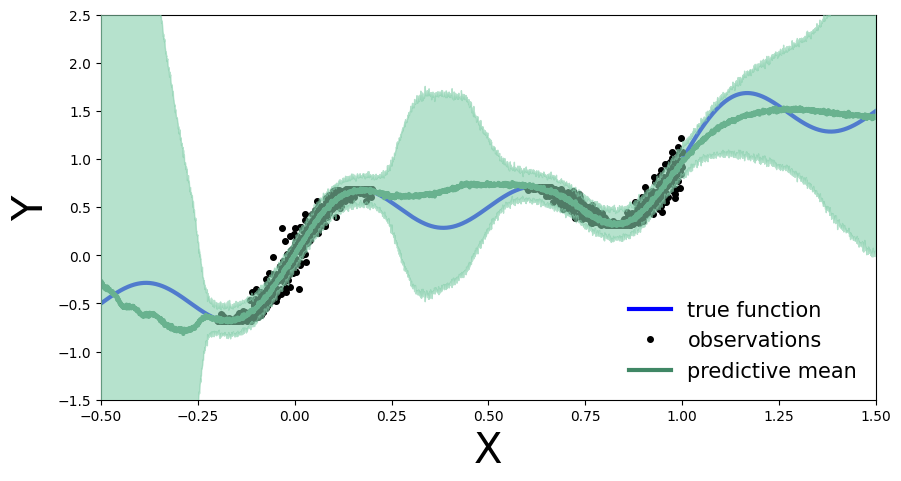

In [37]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_test)
plot_predictions(preds)

### <span style="color:LightGreen">Train BNNs with mean-field variational inference</span>

We will now move on to variational inference. Since the normalized posterior probability density $p(\theta|\mathcal{D})$ is intractable, we approximate it with a tractable parametrized density $q_{\phi}(\theta)$ in a family of probability densities $\mathcal{Q}$. The variational parameters are denoted by $\phi$ and the variational density is called the "guide" in Pyro. The goal is to find the variational probability density that best approximates the posterior by minimizing the KL divergence 

$$ \Large
KL\big(q_{\phi}(\theta)||p(\theta|\mathcal{D})\big)
$$

with respect to the variational parameters.

However, directly minimizing the KL divergence is not tractable because we assume that the posterior density is intractable. To solve this, we use Bayes theorem to obtain

$$ \Large
\log p(\mathcal{D}|\theta) = KL\big(q_{\phi}(\theta)||p(\theta|\mathcal{D})\big) + ELBO(q_{\phi}(\theta)),
$$

where $ELBO(q_{\phi}(\theta))$ is the *Evidence Lower Bound*, given by

$$ \Large
ELBO(q_{\phi}(\theta)) = \mathbb{E}_{\theta \sim q_{\phi}(\theta)}\big[\log p(y|x,\theta) \big] - KL\big(q_{\phi}(\theta) || p(\theta) \big).
$$

By maximizing the ELBO, we indirectly minimize the KL divergence between the variational probability density and the posterior density.

Set up for stochastic variational inference with the variational density $q_{\phi}(\theta)$ by using a normal probability density with a diagonal covariance matrix:

In [38]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

As before, we compute the predictive distribution sampling from the trained variational density.

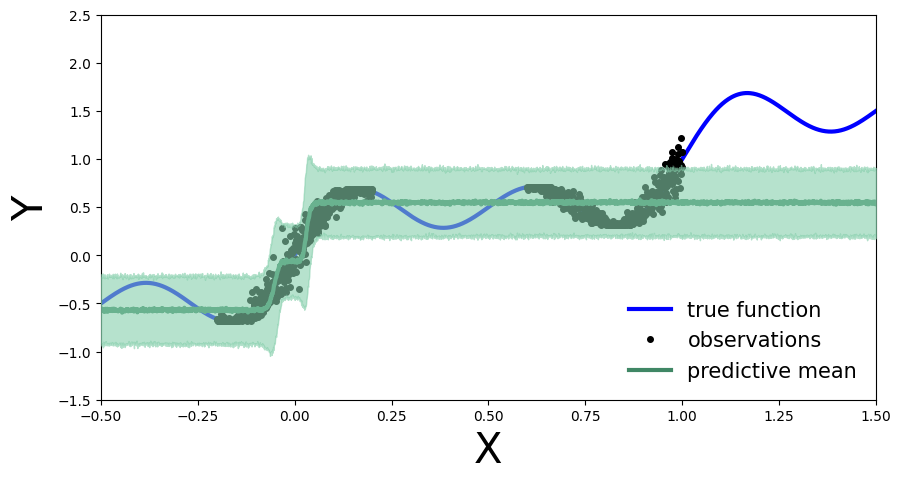

In [39]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)
plot_predictions(preds)

## <span style="color:Orange">Exercise 2: Bayesian updating with variational inference</span>

What happens if we obtain new data points, denoted as $\mathcal{D}'$, after performing variational inference using the observations $\mathcal{D}$?

/tmp/ipykernel_5175/1208744758.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_new, y_new, 'ko', markersize=4, label="New observations", c="r")


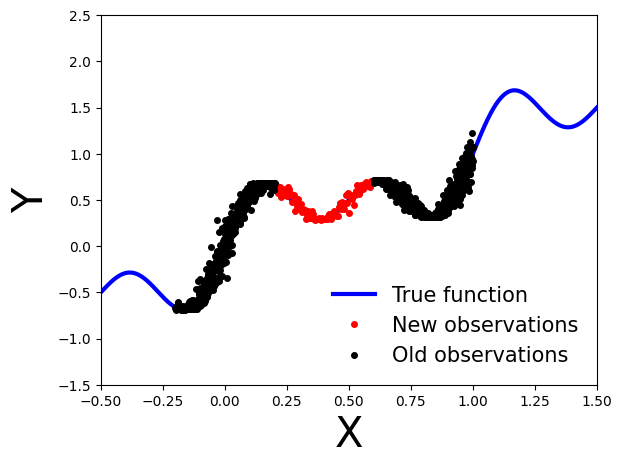

In [40]:
# Generate new observations
x_new = np.linspace(0.2, 0.6, 100)
noise = 0.02 * np.random.randn(x_new.shape[0])
y_new = x_new + 0.3 * np.sin(2 * np.pi * (x_new + noise)) + 0.3 * np.sin(4 * np.pi * (x_new + noise)) + noise

# Generate true function
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

# Set axis limits and labels
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

# Plot all datasets
plt.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
plt.plot(x_new, y_new, 'ko', markersize=4, label="New observations", c="r")
plt.plot(x_obs, y_obs, 'ko', markersize=4, label="Old observations")
plt.legend(loc=4, fontsize=15, frameon=False)
plt.show()

### <span style="color:LightGreen">Bayesian update</span>

How can we perform a Bayesian update on the model using variational inference when new observations become available?

We can use the previously calculated posterior probability density as the new prior and update the posterior with the new observations. Specifically, the updated posterior probability density is given by:

$$ \Large
p(\theta|\mathcal{D}') = \frac{p(\mathcal{D}'|\theta)q_{\phi}(\theta)}{\int p(\mathcal{D}'|\theta)q_{\phi}(\theta)}
$$

Note that we want to update our model using only the new observations $\mathcal{D}'$, relying on the fact that the variational density used as our new prior carries the necessary information on the old observations $\mathcal{D}$.

### <span style="color:LightGreen">Implementation in Pyro</span>

To implement this in Pyro, we can extract the variational parameters (mean and standard deviation) from the `guide` and use them to initialize the prior in a new model that is similar to the original model used for variational inference.

From the Gaussian `guide` we can extract the variational parameters (mean and standard deviation) as:

```python
mu = guide.get_posterior().mean
sigma = guide.get_posterior().stddev
```

### <span style="color:LightGreen">Exercise 2.1 Learn a model on the old observations</span>

First, as before, we define a model using Gaussian prior $\mathcal{N}(\mathbf{0}, 10\cdot \mathbb{I})$.

> Train a model `MyFirstBNN` on the old observations $\mathcal{D}$ using variational inference with `AutoDiagonalNormal()` as guide.

In [41]:
from pyro.optim import Adam
pyro.set_rng_seed(42)
pyro.clear_param_store()

model = MyFirstBNN()
guide = AutoDiagonalNormal(model)
optim = Adam({"lr": 0.03})
svi = pyro.infer.SVI(model, guide, optim, loss=Trace_ELBO())

num_iterations = 10000
progress_bar = trange(num_iterations)

for j in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))

  0%|          | 0/10000 [00:00<?, ?it/s]

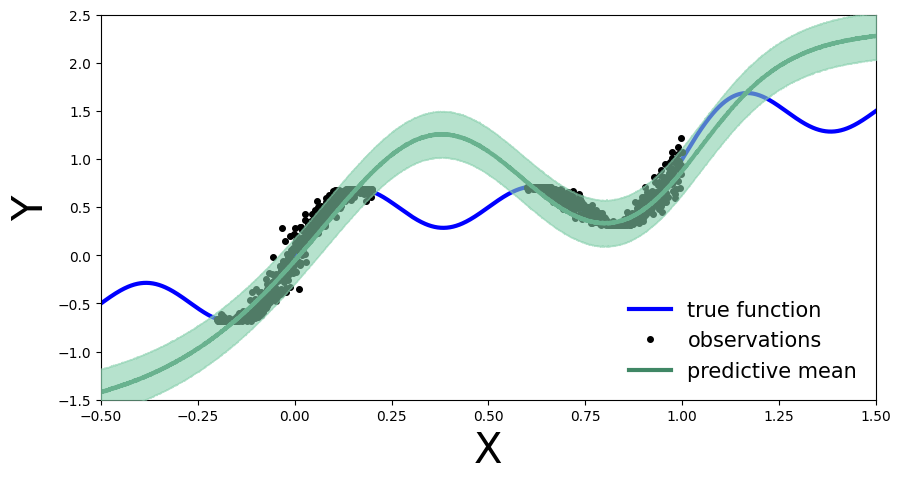

In [42]:
predictive = Predictive(model, guide=guide, num_samples=5000)
preds = predictive(x_test)
plot_predictions(preds)

Next, we can extract the variational parameters (mean and standard deviation) from the `guide` and use them to initialize the prior in a new model that is similar to the original model used for variational inference.

In [43]:
# Extract variational parameters from guide
mu = guide.get_posterior().mean.detach()
stddev = guide.get_posterior().stddev.detach()

In [44]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([ 4.4192,  2.0755,  2.5233,  2.9758, -2.8464, -4.5504, -0.6823,  8.6832,
         8.4492,  1.4790,  1.2583,  5.1179,  0.9285, -1.8940,  4.3386,  1.2919,
        -1.0739], requires_grad=True)
AutoDiagonalNormal.scale tensor([1.4527e-02, 2.4028e-03, 2.1597e+00, 1.6082e+00, 4.6766e-03, 1.4399e-02,
        1.4626e-03, 1.5904e+00, 8.8780e-01, 2.9017e-03, 6.1737e-03, 9.5350e-03,
        6.3800e-03, 5.4559e-03, 7.9139e-03, 5.9698e-03, 4.8265e-02],
       grad_fn=<SoftplusBackward0>)


### <span style="color:LightGreen">Exercise 2.2 Initialize a second model with the variational parameters</span>

> Define a new model similar to `MyFirstBNN(PyroModule)`, that takes the variational parameters and uses them to initialize the prior.

In [45]:
class UpdatedBNN(PyroModule):
    def __init__(self, mu, stddev, in_dim=1, out_dim=1, hid_dim=5):
        super().__init__()
        self.mu = mu
        self.stddev = stddev

        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)

        self.layer1.weight = PyroSample(dist.Normal(self.mu[0:5].unsqueeze(1), self.stddev[0:5].unsqueeze(1)).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(self.mu[5:10], self.stddev[5:10]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(self.mu[10:15].unsqueeze(0), self.stddev[10:15].unsqueeze(0)).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(self.mu[15:16], self.stddev[15:16]).to_event(1))
        # 17th parameter is parameter sigma from the Gamma distribution

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

### <span style="color:LightGreen">Exercise 2.3 Perform variational inference on the new model</span>

### 
> Then perform variational inference on this new model using the new observations and plot the predictive distribution.
> What do you observe? How does the predictive distribution compare to the one obtained in Exercise 2.1?

In [46]:
x_train_new = torch.from_numpy(x_new).float()
y_train_new = torch.from_numpy(y_new).float()

pyro.clear_param_store()
new_model = UpdatedBNN(mu, stddev)
new_guide = AutoDiagonalNormal(new_model)
optim = Adam({"lr": 0.01})
svi = pyro.infer.SVI(new_model, new_guide, optim, loss=Trace_ELBO())

num_iterations = 1000
progress_bar = trange(num_iterations)

for j in progress_bar:
    loss = svi.step(x_train_new, y_train_new)
    progress_bar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))


  0%|          | 0/1000 [00:00<?, ?it/s]

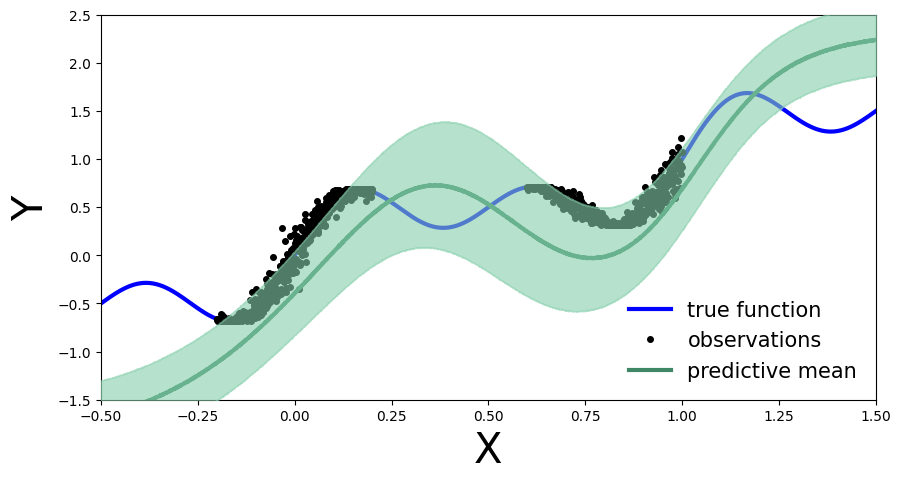

In [47]:
predictive = Predictive(new_model, guide=new_guide, num_samples=5000)
preds = predictive(x_test)
plot_predictions(preds)

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer
* Authors: Ilze Amanda Auzina, Leonard Bereska, Alexander Timans and Eric Nalisnick
* From https://uvadlc-notebooks.readthedocs.io/en/latest/index.html

© Copyright 2025